# Titanic: Machine Learning from Disaster

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

I would like to thank LD Freeman for his great notebook ['A Data Science Framework: To Achieve 99% Accuracy'](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy). This notebook provides a great insight on how to analyze and process and your data. 

# Feature Engineering & Data Exploration

Let's import our necessary libraries for data analysis and get started.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # Setting pandas to display a N number of columns
pd.set_option('display.max_rows', None) # Setting pandas to display a N number rows
pd.set_option('display.width', 1000) # Setting pandas dataframe display width to N

import pandas_profiling 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('Titanic train.csv')
test = pd.read_csv('Titanic test.csv')
dataset = [train, test]

# Let's get a summary of our datasets

print('Entries in training set: ', len(train), '\nEntries in testing set: ',len(test))

for df in dataset:
    print(df.isna().sum())

# A combination of training and test dataset would be helpful in data analysis

train_test_comb = pd.concat([train, test], axis=0)

Entries in training set:  891 
Entries in testing set:  418
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# What to Do With The Null Values!
Let's work with null values first. As we can see from the info table of both datasets that we have null values present in 4 columns: 'Age', 'Cabin', 'Embarked' & 'Fare'. 

* Dropping the 'Age' column wouldn't be wise cause, we can guess that age played an important role in a passenger's survival possibility. Let's see what we can do with for the missing values. See that, the age data for all the 1391 passengers is **normally distributed** (which is what we would expect), so we can **replace the missing values with the mean of the normal distribution**.
* As 'Cabin''s **null value percentage is higher than 50%** we'll simply drop it.
* 'Fare' has only 1 missing value, replace it with the median of fare.
* 'Embarked' has 2 missing values we will simply replace them with 'S' (Southampton)


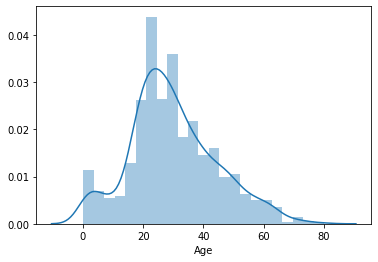

In [3]:
# Visualizing the 'Age' distribution among the passengers
sns.distplot(train_test_comb['Age'])

# Replace 'Age' column missing values with mean
for df in dataset:
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    
# Drop the 'Cabin' column
for df in dataset:
    df.drop(['Cabin'], axis=1, inplace=True)  
    
    
# Replace 'Embarked' column missing values with 'S'
for df in dataset:
    df['Embarked'].fillna('S', inplace=True)

# Create New Feature Columns
Now, notice in the dataset there are 2 columns named **'SibSp' (no. of siblings and spouses) and 'Parch' (no. of parents and children)**. These contain family information, how many members are there in a family excluding the passenger. Instead of using two seperate columns let's create a new column **'Familysize'** by adding the total numbers of sibsp and parch.


The name column can seem like a a feature that won't be necessary because obviously, you won't decide if a person will survive a disaster depending on his name!
That just won't make sense.

BUT BUT BUT wait! The title can be useful right? Like see some passengers hold the 'Master' title. Don't you think they would be a little bit privileged to get a seat on the life boat than other passengers?
Let's extract the titles from the name column, make a new column title and let's find out if survival really depends on the title!

We will split the namestrings and extract the titles and make a new column. The column will have these values: 
> ['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']

An then we will replace the titles having a lower frequency say, has less than 20 ocurrences, with 'Misc'. This way our data will look a lot cleaner as we have fewer categories to work with.


In [4]:
# Create new 'Familysize' and 'Title' column

for df in dataset:
    df['Familysize'] = df['SibSp']+df['Parch']
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    #print(list(df['Title'].unique()))

    # Replace the titles that has less than 20 ocurrences with 'Misc'
    title_names = (df['Title'].value_counts()> 10) #this will create a true false series with title name as index
    
    df['Title'] = df['Title'].apply(lambda x: x if title_names.loc[x] == True else 'Misc')

    
# Let's do this again as we have new features
train_test_comb = pd.concat([train, test], axis=0)

print(train_test_comb['Title'].value_counts())

Mr        757
Miss      260
Mrs       197
Master     61
Misc       34
Name: Title, dtype: int64


# Now Time For Some Plots & Charts!

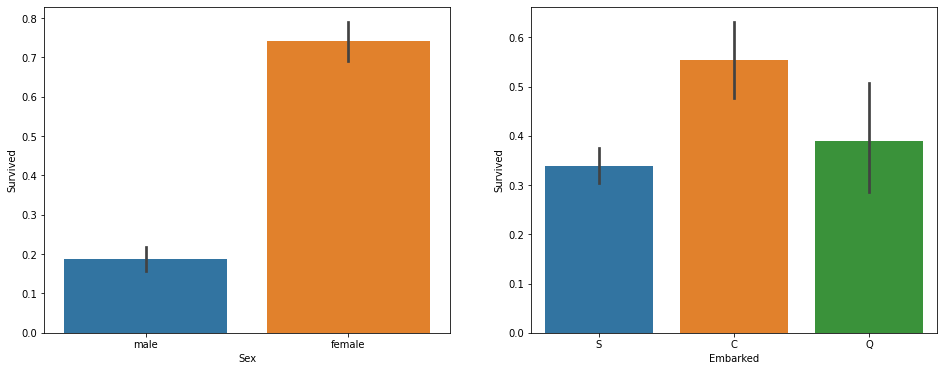

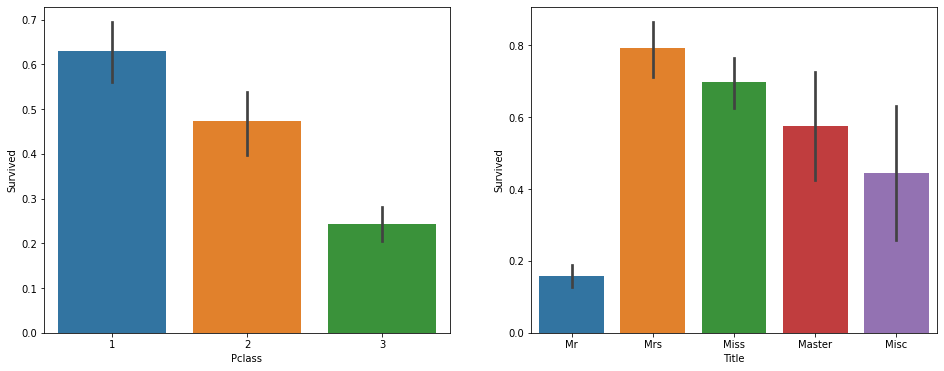

In [5]:
# Some barplots for the discrete features sex, embarked, passengerclass and title, with respect to survival

fig, ax= plt.subplots(1,2, figsize=(16,6))
sns.barplot(x = 'Sex', y = 'Survived', ax = ax[0], data=train)
sns.barplot(x = 'Embarked', y = 'Survived', ax = ax[1], data=train)

fig, ax= plt.subplots(1,2, figsize=(16,6))
sns.barplot(x = 'Pclass', y = 'Survived', ax = ax[0], data=train)
sns.barplot(x = 'Title', y = 'Survived', ax = ax[1], data=train)

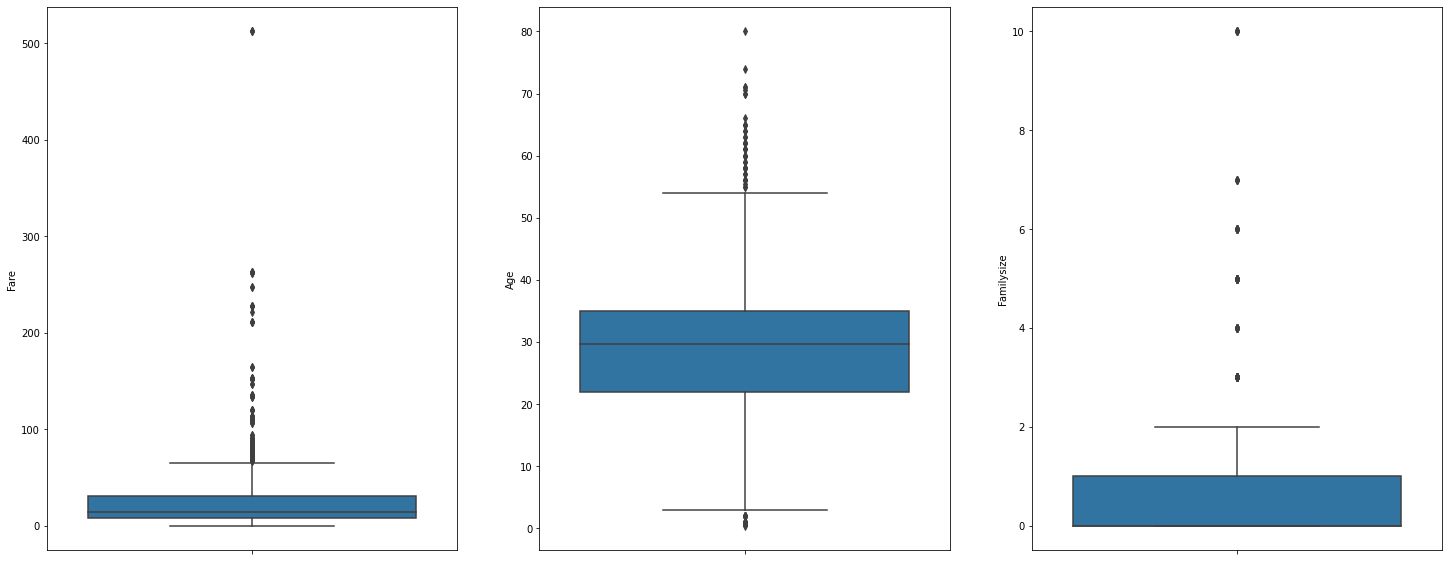

In [6]:
# Boxplots for continuos features like age, fare and familysize

fig, ax= plt.subplots(1,3, figsize=(25,10))
sns.boxplot(x='Fare', orient='v', meanline = False, ax= ax[0], data=train)
sns.boxplot(x='Age', orient='v', meanline = False, ax= ax[1], data=train)
sns.boxplot(x='Familysize', orient='v', meanline = False, ax= ax[2], data=train)

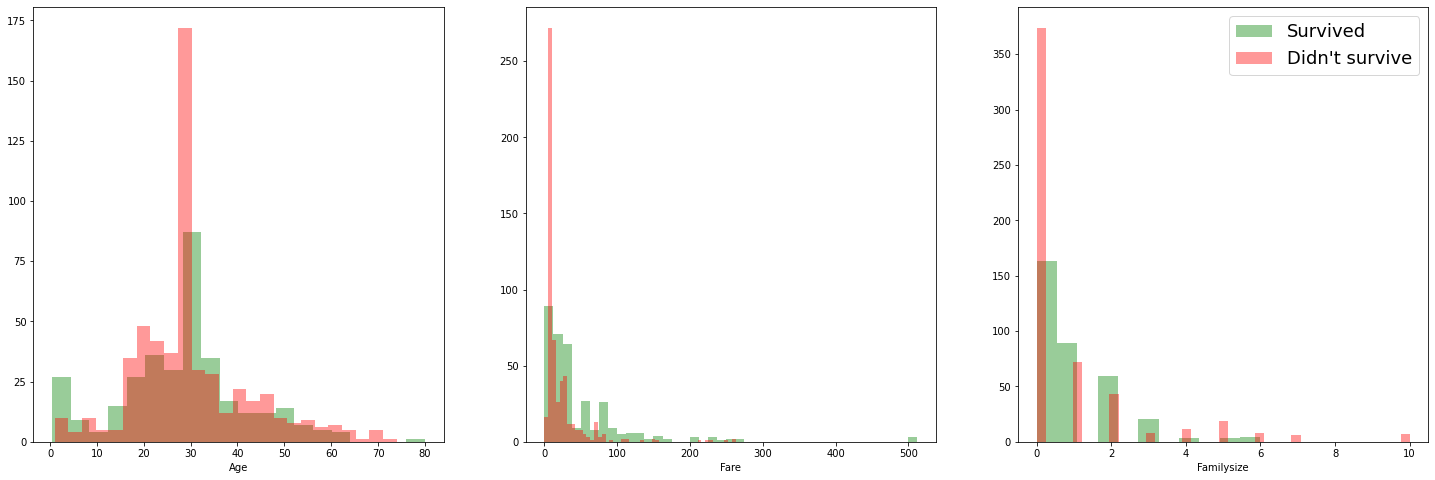

In [7]:
# Histogram of age, fare and familysize by Survival

fig, ax= plt.subplots(1, 3, figsize=(25, 8))
sns.distplot( train[train['Survived']==1]['Age'] , kde=False, label='Survived', color='g', ax=ax[0])
sns.distplot( train[train['Survived']==0]['Age'] , kde=False, label='Didn\'t survive', color='r', ax=ax[0])

sns.distplot(train[train['Survived']==1]['Fare'], kde=False, label='Survived', color = 'g', ax=ax[1])
sns.distplot(train[train['Survived']==0]['Fare'], kde=False, label='Didn\'t survive', color = 'r', ax=ax[1])

sns.distplot(train[train['Survived']==1]['Familysize'], kde=False, label='Survived', color = 'g', ax=ax[2])
sns.distplot(train[train['Survived']==0]['Familysize'], kde=False, label='Didn\'t survive', color = 'r', ax=ax[2])

plt.legend(prop={'size': 18})

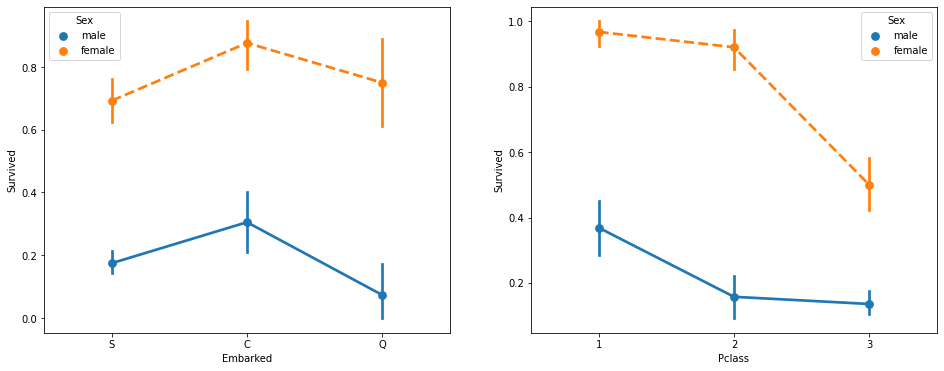

In [8]:
fig, ax = plt.subplots(1, 2,figsize=(16,6))

sns.pointplot(x="Embarked", y="Survived", hue="Sex", data=train, linestyles=["-", "--"], ax = ax[0])
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train, linestyles=["-", "--"], ax = ax[1])

Visualization of data makes it very easy for us to analyse the data. We can understand the relation between a feature and the target from these plots. 

Like from the **barplot of sex vs. survived** we can see that around 75% women survived the disaster whereas only around 20% of the men survived. 

From the **histogram of the familysize by survival** we see that, passengers whose familysize was 0, meaning alone passengers had a very low survival rate.

The pointplots show how does embarked and class factor with sex & survival.

# Data Formatting i.e. Discretization, Datatype Coversion

We will convert the continuous features into discrete categories for the sake of our model to classify the data with a higher accuracy. 

* We will use pandas' quantile-based discretization function [pandas.qcut()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html) (see the documentation for further reading) to discretize 'Age' & 'Fare' into 4 quantile based buckets.

* We will categorize the familysize into 4 categories:
> Alone (family size= 0), Small (familysize = 1,2,3,4), Medium (familysize = 5,6), Large (familysize = larger than 6)

Let's make some plots again!

In [9]:
for df in dataset:
    df['Fare_cat'] = pd.qcut(df['Fare'], q=4, labels=(1,2,3,4))
    df['Age_cat'] = pd.qcut(df['Age'], q=4, labels=(1,2,3,4))
    
    # lambda function to change the values of 'Familysize'
    df['Familysize'] = df['Familysize'].apply(lambda x: 'Alone' if x==0 else('Small' if x>0 and x<5 else('Medium' if x>=5 and x<7 else 'Large')))

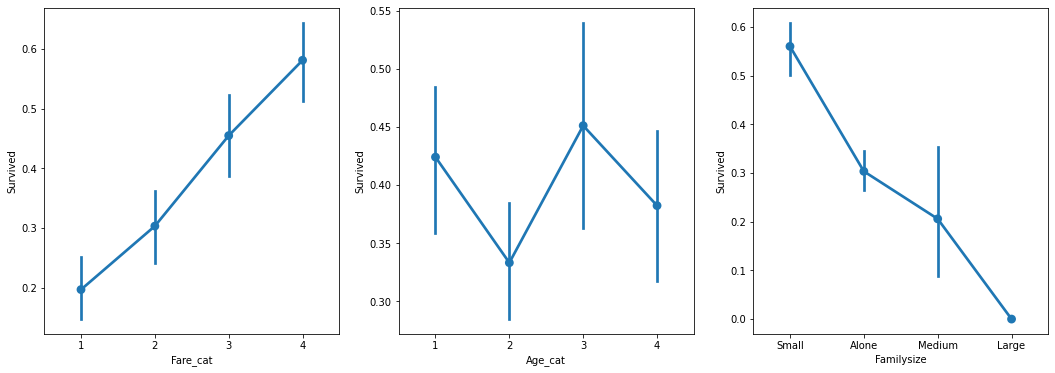

In [10]:
fig, ax = plt.subplots(1, 3,figsize=(18,6) )   

sns.pointplot(x = 'Fare_cat', y = 'Survived',  data=train, ax = ax[0])
sns.pointplot(x = 'Age_cat', y = 'Survived',  data=train, ax = ax[1])
sns.pointplot(x = 'Familysize', y = 'Survived', data=train, ax = ax[2])

In [11]:
# Convert categorical dtypes into numerical dtypes
for df in dataset:
    # Convert category dtypes to integers
    df['Age_cat'] = df['Age_cat'].astype(np.int32)
    df['Fare_cat'] = df['Fare_cat'].astype(np.int32)
    
    # Replace string values with integer values
    df.Title.replace({'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4, 'Misc':5}, inplace=True)
    df.Sex.replace({'female':0, 'male': 1}, inplace=True)
    df.Embarked.replace({'S':1, 'C':2, 'Q':3}, inplace=True)

# One Hot Encoding

Ahem, why do we need one hot encoding? 

One hot encoding allows the representation of categorical data to be more expressive hence the model just works better!

To have a better understanding head over here: [https://bambielli.com/til/2018-02-11-one-hot-encoding/](https://bambielli.com/til/2018-02-11-one-hot-encoding/)

In [13]:
# One-hot encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

features = ['Age_cat', 'Fare_cat', 'Pclass', 'Sex', 'Embarked', 'Title', 'Familysize']
encoded_fearures = []

for df in dataset:
  for feature in features:
    encoded = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    n = df[feature].nunique()
    cols = [f'{feature}_{n}' for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded, columns=cols)
    encoded_df.index = df.index
    encoded_fearures.append(encoded_df)

train_one = pd.concat([train, *encoded_fearures[:7]], axis=1)
test_one = pd.concat([test, *encoded_fearures[7:]], axis=1)

dataset = [train_one, test_one]

In [14]:
for df in dataset:
    print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Familysize', 'Title', 'Fare_cat', 'Age_cat', 'Age_cat_1', 'Age_cat_2', 'Age_cat_3', 'Age_cat_4', 'Fare_cat_1', 'Fare_cat_2', 'Fare_cat_3', 'Fare_cat_4', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_1', 'Sex_2', 'Embarked_1', 'Embarked_2', 'Embarked_3', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Title_5', 'Familysize_1', 'Familysize_2', 'Familysize_3', 'Familysize_4'], dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Familysize', 'Title', 'Fare_cat', 'Age_cat', 'Age_cat_1', 'Age_cat_2', 'Age_cat_3', 'Age_cat_4', 'Fare_cat_1', 'Fare_cat_2', 'Fare_cat_3', 'Fare_cat_4', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_1', 'Sex_2', 'Embarked_1', 'Embarked_2', 'Embarked_3', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Title_5', 'Familysize_1', 'Familysize_2', 'Familysize_3', 'Familysize_4'], dtype='object')


# Get Rid of Redundant Data

Look at the number of columns we have! Let's drop allll the redundant ones, and we will only have the one hot encoded columns.


In [15]:
for df in dataset:
  df.drop(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 
           'Ticket', 'Fare', 'Embarked', 'Familysize', 'Title', 'Fare_cat', 'Age_cat' ], axis=1, inplace=True)

# It's Time For The Machine To Learn!

Now that we have gone through all the data anaysis and preprocessing steps, we are now going to train our model!

Here I am gonna use two types of model:
A **random forest classifier** and then a **neural network**. Now I know that you don't really need to call in the big gun 'neural network' here. But meh, I'll just do it. You always have more hyperparametrs and optimizations available in a neural network so it's fun to work with!

Let's first split the dataset into 95% training and 5% validation data. 
We have only 891 entries, that's a very small dataset so we will keep only 5% (45 entries) for validation.

In [16]:
from sklearn.model_selection import train_test_split

features = [x for x in train_one.columns if x!='Survived']

x = train_one[features].to_numpy()
y = train_one['Survived'].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = int(0.95*len(train_one)), shuffle=False ,random_state=1400)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(846, 25) (846,) (45, 25) (45,)


# Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

clf = RandomForestClassifier(criterion='gini', 
                        n_estimators=300,
                        max_depth=4,
                        min_samples_split=4,
                        min_samples_leaf=7,
                        max_features='auto',
                        oob_score=True,
                        random_state=1400,
                        n_jobs=-1)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)

cm = confusion_matrix(y_val, y_pred)
print(cm)
print(classification_report(y_val, y_pred))

[[23  5]
 [ 3 14]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.74      0.82      0.78        17

    accuracy                           0.82        45
   macro avg       0.81      0.82      0.81        45
weighted avg       0.83      0.82      0.82        45



In [18]:
test_data = test_one[features].to_numpy()

prediction_clf = clf.predict(test_data)
print(len(prediction_clf))

output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': prediction_clf})
output

418


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


# Neural Network

In [19]:
# Using Tensorflow Neural Network
import tensorflow as tf
import tensorflow.keras as keras

seed = 1400

tf.random.set_seed(seed)
my_init = keras.initializers.glorot_uniform(seed=seed)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(x_train.shape[1],)))
model.add(keras.layers.Dense(360, activation='selu', kernel_initializer=my_init))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(360, activation='selu', kernel_initializer=my_init))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(360, activation='selu', kernel_initializer=my_init))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss = keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, mode='max', restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=3, mode='max', min_lr=0)

model.fit(x_train, y_train, epochs = 50, batch_size = 2, callbacks=[reduce_lr, early_stopping], verbose = 1)

val_loss, val_acc = model.evaluate(x_val, y_val, verbose=1)
print('\nValidation accuracy:', val_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 360)               9360      
_________________________________________________________________
dropout (Dropout)            (None, 360)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 360)               129960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 360)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 360)               129960    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 361       
Total params: 269,641
Trainable params: 269,641
Non-trainable params: 0
__________________________________________________

In [21]:
target_col =[]

test_data = test_one[features].to_numpy()
prediction_nn = model.predict(test_data)

for i in prediction_nn:
  target_col.append(int(round(i[0])))

output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': target_col})
output
#output.to_csv('my_submission.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


# The End

My neural network had a slightly better accuracy than the random forest classifier because, I put in more effort in tuning my neural network than tuning the random forest,that's all. You could get this accuracy from the random forest too with a little bit of fine-tuning.

Performance of a machine learning model depends on two major tasks. 
* Data analysis and preprocessing &
* Optimization of your model things like hyperparameter optimaization, weight initialization, seeding etc. 

Deeper analysis of data will get you more accuracy.

That's all guys. Thank you for giving it a read!
Any kind of constructive criticism will be appreciated. Sayonara!